<a href="http://landlab.github.io"><img style="float: left; height: 175px; width: 175px" src="../landlab_logo_picture.jpg"></a> <h3 style="margin: 117px 0 0 185px; font-weight: 300;">a toolkit for modeling earth surface processes</h3>

# Getting to know the Landlab component library

<hr>
<small> For instructions on how to run an interactive IPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

This IPython notebook walks you through the stages of creating and running a Landlab model using the Landlab component library.

We are going to create three models—firstly a single component driver implementing just linear diffusion; then a three-component driver implementing linear diffusion, flow routing, and stream power incision; and finally a similar model, but implementing a storm-interstorm sequence.

Let's begin with the one-component diffusion model.

Firstly, import the library elements we'll need:

In [1]:
from landlab.components.diffusion import LinearDiffuser
from landlab import ModelParameterDictionary
from landlab.plot.imshow import imshow_node_grid
from landlab import RasterModelGrid
import numpy as np
import pylab

Now we're going to instantiate the objects we'll need. The input file, [component_tutorial_params.txt](./component_tutorial_params.txt), in the same folder as this document, contains all the input data we need to set up the grid and initial conditions as well as the components. We're going to load those as well:

In [2]:
input_file = './component_tutorial_params.txt'
inputs = ModelParameterDictionary(input_file) # load the data into an MPD
nrows = inputs.read_int('nrows')
ncols = inputs.read_int('ncols')
dx = inputs.read_float('dx')
leftmost_elev = inputs.read_float('leftmost_elevation')
initial_slope = inputs.read_float('initial_slope') # this is zero
uplift_rate = inputs.read_float('uplift_rate')
runtime = inputs.read_float('total_time')
dt = inputs.read_float('dt')
nt = int(runtime // dt) # this is how many loops we'll need
uplift_per_step = uplift_rate * dt

...now instantiate the grid object:

In [3]:
mg = RasterModelGrid(nrows, ncols, dx) #the grid

...and put the data into the elevation field:

In [4]:
z = mg.add_zeros('node', 'topographic__elevation')

In [5]:
z += leftmost_elev

The next line illustrates one way to create a sloping initial surface. In our case, however, the `initial_slope` parameter is set to zero in the input file, meaning that we're actually starting with a flat surface in this example (try experimenting with `initial_slope` in the input file and re-running to see what this does).

In [6]:
z += (initial_slope * np.amax(mg.node_y)) - (initial_slope * mg.node_y) 

...and add a little random roughness:

In [7]:
z += np.random.rand(z.size) / 100000.

Set the boundary conditions. Always do this after putting the data into the fields.

In [8]:
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

In [9]:
mg.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)

Now, instantiate the component. It's also best practice to do this after both loading the data into the fields and setting the boundary conditions.

In [10]:
lin_diffuse = LinearDiffuser(mg, input_file)

Perform the loop that operates the model.

In [11]:
elapsed_time = 0.
keep_running = True
while keep_running:
    if elapsed_time + dt > runtime:
        dt = runtime - elapsed_time
        keep_running = False
    lin_diffuse.diffuse(dt) # do the diffusion
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step # add the uplift
    elapsed_time += dt

Now plot the output!

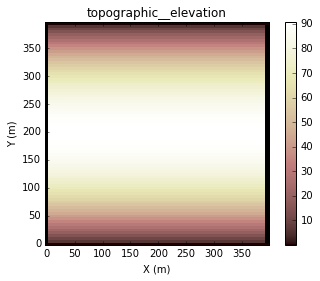

In [12]:
# the following line makes figures show up correctly in this document (only needed for iPython notebook)
%matplotlib inline

# Create a figure and plot the elevations
pylab.figure(1)
im = imshow_node_grid(mg, 'topographic__elevation', grid_units = ['m','m'])

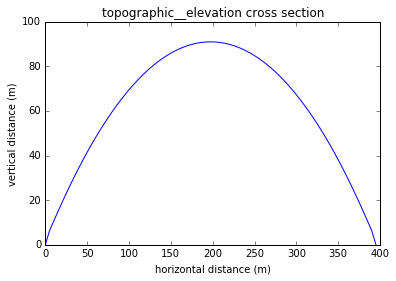

In [13]:
pylab.figure(2)
elev_rast = mg.node_vector_to_raster(mg.at_node['topographic__elevation'])
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
im = pylab.plot(ycoord_rast[:, int(ncols // 2)], elev_rast[:, int(ncols // 2)])
pylab.xlabel('horizontal distance (m)')
pylab.ylabel('vertical distance (m)')
pylab.title('topographic__elevation cross section')

Now we're going to take a similar approach but this time combine the outputs of three distinct Landlab components: the diffuser, the monodirectional flow router, and the stream power incisor. For clarity, we're going to repeat the whole process from the start.

So first, let's import everything:

In [14]:
from landlab.components.flow_routing import FlowRouter
from landlab.components.stream_power import StreamPowerEroder
from landlab.components.diffusion import LinearDiffuser
from landlab import ModelParameterDictionary
from landlab.plot.imshow import imshow_node_grid
from landlab import RasterModelGrid
import numpy as np
import pylab

And again, get all the parameters we need to set up. Note this time we've switched units to ``km`` and artificially accelerated some rates to improve model performance, reflected in the [new input file](./coupled_params.txt).

In [15]:
input_file = './coupled_params.txt'
inputs = ModelParameterDictionary(input_file) # load the data into an MPD
nrows = inputs.read_int('nrows')
ncols = inputs.read_int('ncols')
dx = inputs.read_float('dx')
leftmost_elev = inputs.read_float('leftmost_elevation')
initial_slope = inputs.read_float('initial_slope') # this is zero
uplift_rate = inputs.read_float('uplift_rate')
runtime = inputs.read_float('total_time')
dt = inputs.read_float('dt')
nt = int(runtime // dt) #this is how many loops we'll need
uplift_per_step = uplift_rate * dt

And instantiate the grid, set the initial conditions, and set the boundary conditions:

In [16]:
mg = RasterModelGrid(nrows, ncols, dx)
z = mg.add_zeros('node', 'topographic__elevation')
z += leftmost_elev
z += (initial_slope * np.amax(mg.node_y)) - (initial_slope * mg.node_y)
initial_roughness = np.random.rand(z.size)/100000.
z += initial_roughness
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
mg.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)

So far, so familiar. Now we're going to instantiate all our components:

In [17]:
fr = FlowRouter(mg) # note the flow router doesn't have to take an input file
sp = StreamPowerEroder(mg, input_file)
lin_diffuse = LinearDiffuser(mg, input_file)

And now we run! We're going to run once with the diffusion and once without.

In [18]:
elapsed_time = 0.
keep_running = True
counter = 0 # simple incremented counter to let us see the model advance
while keep_running:
    if elapsed_time + dt > runtime:
        dt = runtime - elapsed_time
        keep_running = False
    # _ = lin_diffuse.diffuse(dt) no diffusion this time
    _ = fr.route_flow() # route_flow isn't time sensitive, so it doesn't take dt as input
    _ = sp.erode(mg, dt=dt)
    # this component is of an older style,
    # so it still needs a copy of the grid to be passed
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step # add the uplift
    elapsed_time += dt
    if counter % 50 == 0:
        print ('Completed loop %d' % counter)
    counter += 1

Completed loop 0
Completed loop 50
Completed loop 100
Completed loop 150
Completed loop 200
Completed loop 250
Completed loop 300
Completed loop 350
Completed loop 400
Completed loop 450
Completed loop 500
Completed loop 550
Completed loop 600
Completed loop 650
Completed loop 700
Completed loop 750
Completed loop 800
Completed loop 850
Completed loop 900
Completed loop 950
Completed loop 1000


Let's see our output this time. You'll need to give the above code a few 10s of seconds to run.

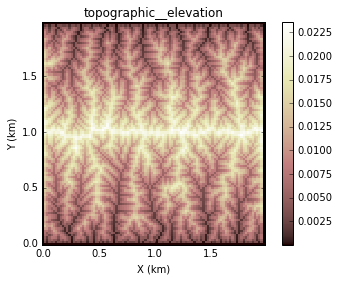

In [19]:
pylab.figure('topo without diffusion')
im = imshow_node_grid(mg, 'topographic__elevation', grid_units=['km','km'])

And now let's reset the grid elevations and do everything again, but this time, with the diffusion turned *on*:

In [20]:
z = mg.add_zeros('node', 'topographic__elevation')
z += leftmost_elev
z += (initial_slope * np.amax(mg.node_y)) - (initial_slope * mg.node_y)
z += initial_roughness
elapsed_time = 0.
keep_running = True
dt = inputs.read_float('dt')
counter = 0
while keep_running:
    if elapsed_time + dt > runtime:
        dt = runtime - elapsed_time
        keep_running = False
    _ = lin_diffuse.diffuse(dt) # diffusion now on
    _ = fr.route_flow()
    _ = sp.erode(mg, dt=dt)
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step # add the uplift
    elapsed_time += dt
    if counter % 50 == 0:
        print ('Completed loop %d' % counter)
    counter += 1

Completed loop 0
Completed loop 50
Completed loop 100
Completed loop 150
Completed loop 200
Completed loop 250
Completed loop 300
Completed loop 350
Completed loop 400
Completed loop 450
Completed loop 500
Completed loop 550
Completed loop 600
Completed loop 650
Completed loop 700
Completed loop 750
Completed loop 800
Completed loop 850
Completed loop 900
Completed loop 950
Completed loop 1000


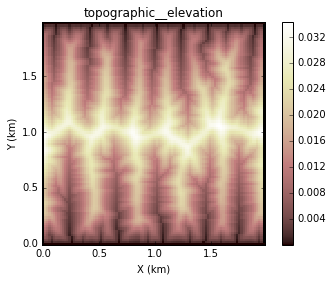

In [21]:
pylab.figure('topo with diffusion')
im = imshow_node_grid(mg, 'topographic__elevation', grid_units=['km','km'])

Beautiful! We've smoothed away the fine-scale channel roughness, as expected, and produced some lovely convex-up hillslopes in its place. Note that even though the initial conditions were identical in both cases, including the roughness, the channel positions have been moved significantly by the hillslope diffusion into the channel.

As a final step, we're going to show off some of Landlab's fancier functionality. We're going to repeat the above coupled model run, but this time we're going to plot some evolving channel profiles, and we're going to drive the simulation with a sequence of storms, not just a fixed timestep. We'll also peoduce a slope-area plot for the final conditions.

So, load the new landlab objects we'll need, then reset the initial conditions:

In [22]:
from landlab.plot import channel_profile as prf
from landlab.components.uniform_precip import PrecipitationDistribution

In [23]:
z = mg.add_zeros('node', 'topographic__elevation')
z += leftmost_elev
z += (initial_slope * np.amax(mg.node_y)) - (initial_slope * mg.node_y)
z += initial_roughness
dt = inputs.read_float('dt')

Instantiate the storm generator:

In [24]:
precip = PrecipitationDistribution(input_file='coupled_params_storms.txt')

Now run:

made it to time 0
made it to time 20
made it to time 40
made it to time 60
made it to time 80
made it to time 100
made it to time 120
made it to time 140
made it to time 160
made it to time 180
made it to time 200
made it to time 220
made it to time 240
made it to time 260
made it to time 280


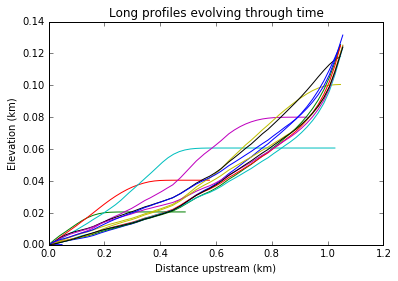

In [25]:
out_interval = 20.
last_trunc = runtime # we use this to trigger taking an output plot
for (interval_duration, rainfall_rate) in precip.yield_storm_interstorm_duration_intensity():
    if rainfall_rate != 0.:
        # note diffusion also only happens when it's raining...
        _ = fr.route_flow()
        _ = sp.erode(mg, interval_duration)
        _ = lin_diffuse.diffuse(interval_duration)
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_rate * interval_duration
    this_trunc = precip.elapsed_time // out_interval
    if this_trunc != last_trunc: # time to plot a new profile!
        print ('made it to time %d' % (out_interval * this_trunc))
        last_trunc = this_trunc
        pylab.figure("long_profiles")
        profile_IDs = prf.channel_nodes(mg, mg.at_node['topographic__steepest_slope'],
                        mg.at_node['drainage_area'], mg.at_node['flow_receiver'])
        dists_upstr = prf.get_distances_upstream(mg, len(mg.at_node['topographic__steepest_slope']),
                        profile_IDs, mg.at_node['links_to_flow_receiver'])
        prf.plot_profiles(dists_upstr, profile_IDs, mg.at_node['topographic__elevation'])
    # no need to track elapsed time, as the generator will stop automatically
# make the figure look nicer:
pylab.figure("long_profiles")
pylab.xlabel('Distance upstream (km)')
pylab.ylabel ('Elevation (km)')
pylab.title('Long profiles evolving through time')

Note that the "wobbles" in the long profile here are being created by the stochastic storm sequence. We could reduce their impact by reducing the storm-interstorm timescales, or allowing diffusion while it's not raining, but we've chosen not to here to show that the storms are having an effect.

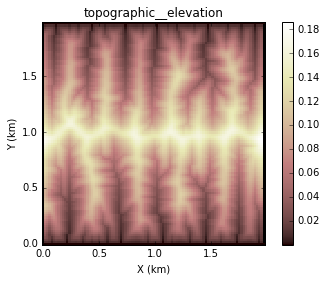

In [26]:
pylab.figure('topo with diffusion and storms')
im = imshow_node_grid(mg, 'topographic__elevation', grid_units=['km','km'])

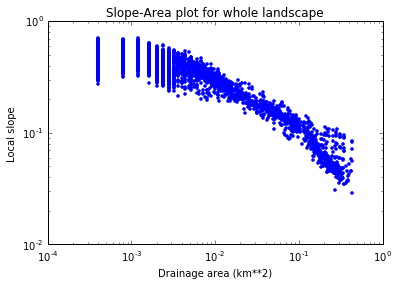

In [27]:
pylab.figure('final slope-area plot')
im = pylab.loglog(mg.at_node['drainage_area'], mg.at_node['topographic__steepest_slope'],'.')
pylab.xlabel('Drainage area (km**2)')
pylab.ylabel('Local slope')
pylab.title('Slope-Area plot for whole landscape')

That's a nice set of figures, eh? You can easily spend more time with pylab prettifying them if you want.

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>